## NLP Class Assignment 6 -- Topic Modeling on Tweets

Richard Yang

You have been provided with a starter notebook that reads a collection of tweets and a collection of news articles about one particular company.  Use appropriate topic modeling technique to identify top N most important topics.  To get quality results apply appropriate text cleaning methods.

- Present top N most important topics in the news articles and tweets
- For news articles, consider how to effectively combine information from the title and text of news article
- Select N to identify relevant topics, but minimize duplication
- Explain how you selected N


In [ ]:
import pandas as pd
import sys
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import re
import string

import nltk as nltk
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer

print('Python Version: ' + sys.version)
print('TensorFlow Version: ' + tf.__version__)

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 500)

Python Version: 3.10.11 (main, Apr  5 2023, 14:15:10) [GCC 9.4.0]
TensorFlow Version: 2.12.0


In [ ]:
#Verify we got CPU + GPU or only CPU
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]

In [ ]:
import bokeh

print('Bokeh Version: ' + bokeh.__version__)

Bokeh Version: 2.4.3


In [ ]:
import ktrain

print('Ktrain Version: ' + ktrain.__version__)

Ktrain Version: 0.36.0


#### Read Tweets data

In [ ]:
tweets_path = 'https://storage.googleapis.com/msca-bdp-data-open/tweets/nlp_a_6_tweets.json'
tweets_df = pd.read_json(tweets_path, orient='records', lines=True)
print(f'Sample contains {tweets_df.shape[0]:,.0f} tweets')
tweets_df.head(2)

Sample contains 9,941 tweets


,id,lang,date,name,retweeted,text
0,1484553027222741001,en,2022-01-21,Dylan Green,RT,*Microsoft has entered the chat* https://t.co/Uz3pZrk6B3
1,1505486305102557184,en,2022-03-20,Rahim Rajwani,,"""I actually use an @Android phone. Some #Android manufacturers pre-install @Microsoft software in a way that makes it easy for me. They’re more flexible about how the software connects up with the OS. So that’s what I ended up getting used to.""\nhttps://t.co/C0VjfS9PUO"


LDA on Tweets

In [ ]:
import os
import time
import math
import re
from pprint import pprint
from textblob import TextBlob
import pandas as pd
import numpy as np


import nltk as nltk
from nltk.corpus import stopwords
# from nltk.stem.wordnet import WordNetLemmatizer
import spacy
import multiprocessing
import string


import gensim
from gensim import corpora, models
from gensim.models.ldamulticore import LdaMulticore
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

import pyLDAvis.gensim
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()

In [ ]:
import warnings

# warnings.simplefilter('once')
warnings.simplefilter('ignore')
# warnings.filterwarnings("ignore", category=FutureWarning)
# warnings.filterwarnings("ignore", category=DeprecationWarning)
# warnings.filterwarnings(action='ignore', category=UserWarning, module='gensim')

In [ ]:
num_processors = multiprocessing.cpu_count()
num_processors

workers = num_processors-1

print(f'Using {workers} workers')

Using 1 workers


Data Cleaning

In [ ]:
# Filter non-English articles, apply appropriate cleaning
%time 
tweets_eng = tweets_df[tweets_df['lang']=='en'].reset_index(drop=True)
tweets_eng = tweets_df['text'].apply(lambda x: re.sub(r'[^\d+\w\s,.]','',x))
tweets_eng = tweets_df['text'].apply(lambda x: re.sub(r'\n|\nm|\nm\n\n','',x))

CPU times: user 8.04 ms, sys: 0 ns, total: 8.04 ms
Wall time: 17.5 ms


#### Tokenize text into words and remove punctuation

In [ ]:
%%time

def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations
        
        
data_list = tweets_eng['text'].tolist()        
data_tokens = list(sent_to_words(data_list))

CPU times: user 1.42 s, sys: 37.1 ms, total: 1.45 s
Wall time: 4.32 s


#### Remove Stopwords, Make n-grams and Lemmatize

In [ ]:
%%time

# bigram = gensim.models.Phrases(data_tokens, min_count=5, threshold=100)
# trigram = gensim.models.Phrases(bigram[data_tokens], threshold=100)

bigram = gensim.models.Phrases(data_tokens, min_count=1, threshold=1)
trigram = gensim.models.Phrases(bigram[data_tokens], threshold=1)

bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

CPU times: user 3.03 s, sys: 24.5 ms, total: 3.06 s
Wall time: 6.87 s


In [ ]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
%%time

stop_words = stopwords.words('english')

# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

CPU times: user 589 µs, sys: 0 ns, total: 589 µs
Wall time: 607 µs


In [ ]:
%%time

# Remove Stop Words
data_tokens_nostops = remove_stopwords(data_tokens)

# Create n-grams
data_words_bigrams = make_bigrams(data_tokens_nostops)
data_words_trigrams = make_trigrams(data_tokens_nostops)

# Combine tokens and n-grams
# data_tokens_cobnined = data_tokens_nostops + data_words_bigrams + data_words_trigrams
data_tokens_cobnined = data_words_trigrams

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])

# Lemmatize text keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_tokens_cobnined, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

In [ ]:
%%time

# Creating the term dictionary of our courpus, where every unique term is assigned an index. 
dictionary = corpora.Dictionary(data_lemmatized)

# Converting list of documents (corpus) into Document Term Matrix using dictionary prepared above.
doc_term_matrix = [dictionary.doc2bow(doc) for doc in data_lemmatized]

CPU times: user 303 ms, sys: 1.06 ms, total: 304 ms
Wall time: 303 ms


#### Build initial 3 topic model

In [ ]:
%%time

lda_model = LdaMulticore(corpus=doc_term_matrix,
                   id2word=dictionary,
                   num_topics=3,
                   random_state=100,
                   passes=10,
                   eta='auto',
                   workers=workers)

CPU times: user 52.5 s, sys: 1.66 s, total: 54.2 s
Wall time: 1min 12s


In [ ]:
# Print the Keyword in the 3 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[doc_term_matrix]

[(0,
  '0.008*"game" + 0.006*"go" + 0.006*"get" + 0.006*"make" + 0.005*"work" + '
  '0.005*"https_co" + 0.004*"company" + 0.004*"say" + 0.004*"well" + '
  '0.004*"buy"'),
 (1,
  '0.014*"https_co" + 0.006*"ever_ever_ever_ever" + 0.005*"new" + '
  '0.003*"support" + 0.003*"use" + 0.003*"product" + 0.003*"learn" + '
  '0.003*"get" + 0.003*"want" + 0.003*"work"'),
 (2,
  '0.016*"know" + 0.013*"https_co" + 0.013*"use" + 0.004*"world_businesse" + '
  '0.004*"learn" + 0.004*"co" + 0.003*"microsoft_https_co" + 0.003*"day" + '
  '0.003*"tip" + 0.002*"check"')]


#### Compute Coherence Score

In [ ]:
%%time

coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.4208980595555272
CPU times: user 501 ms, sys: 12.1 ms, total: 513 ms
Wall time: 521 ms


#### Tune LDA model

In [ ]:
# supporting function
def compute_coherence_values(corpus, dictionary, k, a, b):
    
    lda_model = LdaMulticore(corpus=doc_term_matrix,
                       id2word=dictionary,
                       num_topics=k,
                       random_state=100,                  
                       passes=10,
                       alpha=a,
                       eta=b,
                       workers=workers)
    
    coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=dictionary, coherence='c_v')
    
    return coherence_model_lda.get_coherence()

In [ ]:
start_time = time.time()

def tic():
    global start_time 
    start_time = time.time()

def tac():
    t_sec = round(time.time() - start_time)
    (t_min, t_sec) = divmod(t_sec,60)
    (t_hour,t_min) = divmod(t_min,60) 
    print(f'Execution time to calculate for topic {k}: {t_hour}hour:{t_min}min:{t_sec}sec'.format(t_hour,t_min,t_sec))

In [ ]:
%%time

grid = {}
grid['Validation_Set'] = {}
# Topics range
min_topics = 2
max_topics = 20
step_size = 1
topics_range = range(min_topics, max_topics+2, step_size)

# Alpha parameter
alpha = list(np.arange(0.01, 1, 0.3))
alpha.append('symmetric')
alpha.append('asymmetric')
alpha = ['symmetric'] # Run for number of topics only

# Beta parameter
beta = list(np.arange(0.01, 1, 0.3))
beta.append('symmetric')
beta = ['auto'] # Run for number of topics only


# Validation sets
num_of_docs = len(doc_term_matrix)
corpus_sets = [# gensim.utils.ClippedCorpus(doc_term_matrix, num_of_docs*0.25), 
               # gensim.utils.ClippedCorpus(doc_term_matrix, num_of_docs*0.5), 
#                gensim.utils.ClippedCorpus(doc_term_matrix, num_of_docs*0.75), 
               doc_term_matrix]
# corpus_title = ['75% Corpus', '100% Corpus']
corpus_title = ['100% Corpus']
model_results = {
                 'Topics': [],
                 'Alpha': [],
                 'Beta': [],
                 'Coherence': []
                }

itr = 0
itr_total = len(beta)*len(alpha)*len(topics_range)*len(corpus_title)
print(f'LDA will execute {itr_total} iterations')

    
# iterate through hyperparameters
for i in range(len(corpus_sets)):
    # iterate through number of topics
    for k in topics_range:
        # iterate through alpha values
        tic()
        for a in alpha:
            # iterare through beta values
            for b in beta:
                # get the coherence score for the given parameters
                itr += 1
                cv = compute_coherence_values(corpus=corpus_sets[i], dictionary=dictionary, 
                                              k=k, a=a, b=b)
                # Save the model results
                model_results['Topics'].append(k)
                model_results['Alpha'].append(a)
                model_results['Beta'].append(b)
                model_results['Coherence'].append(cv)
                pct_completed = round((itr / itr_total * 100),1)
#                 print(f'Completed Percent: {pct_completed}%, Corpus: {corpus_title[i]}, Topics: {k}, Alpha: {a}, Beta: {b}, Coherence: {cv}')
        print(f'Completed model based on {k} LDA topics. Finished {pct_completed}% of LDA runs')
        tac()
                    
lda_tuning = pd.DataFrame(model_results)
# lda_tuning.to_csv(os.path.join(path_lda, 'lda_tuning_results.csv'), index=False)

LDA will execute 20 iterations
Completed model based on 2 LDA topics. Finished 5.0% of LDA runs
Execution time to calculate for topic 2: 0hour:1min:9sec
Completed model based on 3 LDA topics. Finished 10.0% of LDA runs
Execution time to calculate for topic 3: 0hour:1min:14sec
Completed model based on 4 LDA topics. Finished 15.0% of LDA runs
Execution time to calculate for topic 4: 0hour:1min:5sec
Completed model based on 5 LDA topics. Finished 20.0% of LDA runs
Execution time to calculate for topic 5: 0hour:1min:3sec
Completed model based on 6 LDA topics. Finished 25.0% of LDA runs
Execution time to calculate for topic 6: 0hour:0min:58sec
Completed model based on 7 LDA topics. Finished 30.0% of LDA runs
Execution time to calculate for topic 7: 0hour:1min:0sec
Completed model based on 8 LDA topics. Finished 35.0% of LDA runs
Execution time to calculate for topic 8: 0hour:0min:57sec
Completed model based on 9 LDA topics. Finished 40.0% of LDA runs
Execution time to calculate for topic 9:

In [ ]:
# Best LDA parameters
lda_tuning.sort_values(by=['Coherence'], ascending=False).head(10)

,Topics,Alpha,Beta,Coherence
0,2,symmetric,auto,0.457395
1,3,symmetric,auto,0.414449
18,20,symmetric,auto,0.396471
13,15,symmetric,auto,0.379204
2,4,symmetric,auto,0.372030
15,17,symmetric,auto,0.369853
3,5,symmetric,auto,0.368870
19,21,symmetric,auto,0.364995
12,14,symmetric,auto,0.362188
6,8,symmetric,auto,0.351849


In [ ]:
# Worst LDA parameters
lda_tuning.sort_values(by=['Coherence']).head(10)

,Topics,Alpha,Beta,Coherence
4,6,symmetric,auto,0.298753
10,12,symmetric,auto,0.316254
7,9,symmetric,auto,0.323985
8,10,symmetric,auto,0.325354
11,13,symmetric,auto,0.325845
5,7,symmetric,auto,0.326185
17,19,symmetric,auto,0.343036
14,16,symmetric,auto,0.346912
16,18,symmetric,auto,0.349275
9,11,symmetric,auto,0.349860


Visualization of Results

<Axes: xlabel='Topics', ylabel='Coherence'>

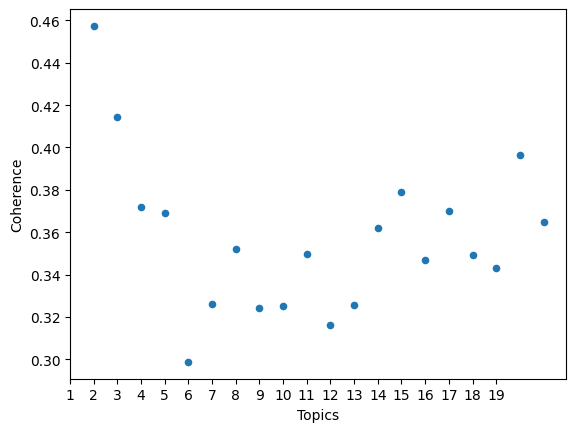

In [ ]:
lda_tuning.plot(x ='Topics', y='Coherence', kind = 'scatter', xticks=range(1,20))

<Axes: xlabel='Topics'>

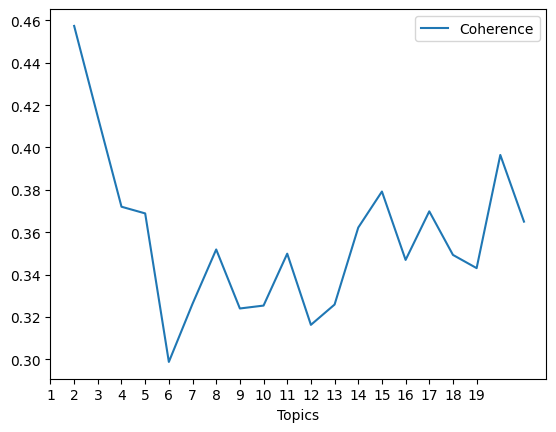

In [ ]:
lda_tuning.plot(x ='Topics', y='Coherence', kind = 'line', xticks=range(1,20))

#### Running best model

In [ ]:
lda_tuning_best = lda_tuning.sort_values(by=['Coherence'], ascending=False).head(1)

tuned_topics = int(lda_tuning_best['Topics'].to_string(index=False))

# Since the values for Alpha and Beta can be float, symmetric and asymmetric, we will either strip or convert to float
try:
    tuned_alpha = float(lda_tuning_best['Alpha'].to_string(index=False))
except:
    tuned_alpha = lda_tuning_best['Alpha'].to_string(index=False).strip()

try:
    tuned_beta = float(lda_tuning_best['Beta'].to_string(index=False))
except:
    tuned_beta = lda_tuning_best['Beta'].to_string(index=False).strip()    
    
print(f'Best Parameters: Topics: {tuned_topics}, Alpha: {tuned_alpha}, Beta: {tuned_beta}')

Best Parameters: Topics: 2, Alpha: symmetric, Beta: auto


In [ ]:
%%time

tuned_lda_model = LdaMulticore(corpus=doc_term_matrix,
                       id2word=dictionary,
                       num_topics=tuned_topics,
                       random_state=100,
                       passes=10,
                       alpha=tuned_alpha,
                       eta=tuned_beta,
                       workers = workers)

coherence_model_lda = CoherenceModel(model=tuned_lda_model, texts=data_lemmatized, dictionary=dictionary, coherence='c_v')
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.4208980595555272
CPU times: user 54.3 s, sys: 1.81 s, total: 56.1 s
Wall time: 1min 10s


In [ ]:
%%time

lda_display = gensimvis.prepare(tuned_lda_model, doc_term_matrix, dictionary, sort_topics=False, mds='mmds')
pyLDAvis.display(lda_display)

CPU times: user 2.36 s, sys: 186 ms, total: 2.55 s
Wall time: 6.99 s


### Summary of Results on Tweets

1. According to the coherence score, the best model is the one with **2** topics. The coherence score is 0.4573.

2. Within the **2** topics, the topic 1 is the most important topic. It contains words like "game", "play", "window", "number", "time", "activation" which might be talking about the game and the activation of the game. The topic 2 is the second most important topic. It contains words like "support", "team", "azure", "microsoft azure", microsoft teams" which might be talking about the support of microsoft related product and the related services.

3. I choose N by hyperparameter tuning. I tried different number of topics and choose the one with the highest coherence score. However, it is neccessary to consider the interpretability of the topics. If the topics are not interpretable, it is not useful to choose the model with the highest coherence score. It is a trade-off between coherence score and interpretability. But in this case, the coherence score and interpretability are both good for the model with **2** topics.

In [1]:
import datetime
import pytz

time = datetime.datetime.now(pytz.timezone('US/Central')).strftime("%a, %d %B %Y %H:%M:%S")
sign = 'Richard Yang'

print(f'Created at: {time} by {sign}')

Created at: Mon, 01 May 2023 23:02:42 by Richard Yang
